In [ ]:
# Import libraries

# Data processing, analysis and visualisation
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Pandas profiling
import pandas_profiling
from pandas_profiling import ProfileReport

# Word cloud visualisation
from wordcloud import WordCloud

# Data pre-processing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer

# Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# To save model
import joblib

In [3]:
# Load the dataset into a pandas dataframe
file_path = "../data/norm_dataset.csv"
df = pd.read_csv(file_path)

In [4]:
# Preview first 5 rows of dataset. Extend the max column width in order to preview the entire sentence column
pd.set_option('display.max_colwidth', None)
df.head()

,text,norm
0,"Client agrees to pay to Company the sum of $5,000 (the “Contract Price”) to design and develop a website for Client (the “Client Website”) in accordance with the accompanying Scope of Work, attached to this Agreement as Exhibit A.",1
1,Company will use its best efforts to deliver the Client Website in the time frame specified in the Scope of Work.,1
2,"All written content submitted by Client for use in the Client Website must be typewritten, proofread and delivered to Company in the body of an email message or as a Microsoft Word electronic document or plaint text electronic document.",1
3,It is Client’s sole responsibility to check the accuracy of the written content and correct any errors prior to submission for final publication.,1
4,Client further agrees that Company may use and display the graphics and other web design elements of Client’s website as examples of Company website design and development work.,1


In [5]:
# Shape of the dataframe
row_count, column_count = df.shape
df.shape

(366, 2)

In [6]:
# Check the data types
df.dtypes

text    object
norm     int64
dtype: object

In [7]:
# Check for null values
df.isnull().sum()

text    0
norm    0
dtype: int64

In [8]:
# Also check if there are any duplicate records
df[df.duplicated(keep=False)]

,text,norm
2,"All written content submitted by Client for use in the Client Website must be typewritten, proofread and delivered to Company in the body of an email message or as a Microsoft Word electronic document or plaint text electronic document.",1
48,"If the adjustment is more than $1,500 in favor, then out-of-pocket costs of such examination shall be borne by Zynga.",1
51,"EXCEPT IN CASES OF GROSS NEGLIGENCE, WILLFUL MISCONDUCT OR FRAUD, INDEMNIFICATION CLAIMS UNDER SECTION 5 OR BREACHES OF SECTION 2 (TRADEMARKS), 8 (CONFIDENTIALITY), OR 9 (NO AGENCY RELATIONSHIP), IN NO EVENT SHALL EITHER PARTY OR ITS OFFICERS, DIRECTORS, OR EMPLOYEES BE LIABLE TO THE OTHER PARTY IN CONNECTION WITH THE SUBJECT MATTER HEREOF, FOR ANY SPECIAL, INDIRECT, CONSEQUENTIAL OR PUNITIVE DAMAGES OF ANY KIND, LOST PROFITS OR LOST REVENUE, WHETHER ARISING IN CONTRACT, TORT, NEGLIGENCE, STATUTE, OR OTHERWISE, EVEN IF ADVISED OF THE POSSIBILITY THEREOF.",1
52,IN NO EVENT SHALL THE NON-BREACHING PARTY BE ENTITLED TO EQUITABLE OR INJUNCTIVE RELIEF OF ANY KIND.,1
60,"Notwithstanding the foregoing, for each end user that previously downloaded a Zynga game that includes WPT’s Licensed Property, and stored such Zynga game within such end user’s device, WPT grants a license and right to continue to use, activate, operate, perform, store, use and display that game on the end user’s device in perpetuity at no additional charge; provided, however, that Zynga shall use best efforts to offer end users updates to its games which no longer include WPT’s Licensed Property after the Term.",1
62,Each party agrees to carry liability insurance sufficient to cover the risks posed under this Agreement.,1
307,"All written content submitted by Client for use in the Client Website must be typewritten, proofread and delivered to Company in the body of an email message or as a Microsoft Word electronic document or plaint text electronic document.",1
308,"If the adjustment is more than $1,500 in favor, then out-of-pocket costs of such examination shall be borne by Zynga.",1
309,"EXCEPT IN CASES OF GROSS NEGLIGENCE, WILLFUL MISCONDUCT OR FRAUD, INDEMNIFICATION CLAIMS UNDER SECTION 5 OR BREACHES OF SECTION 2 (TRADEMARKS), 8 (CONFIDENTIALITY), OR 9 (NO AGENCY RELATIONSHIP), IN NO EVENT SHALL EITHER PARTY OR ITS OFFICERS, DIRECTORS, OR EMPLOYEES BE LIABLE TO THE OTHER PARTY IN CONNECTION WITH THE SUBJECT MATTER HEREOF, FOR ANY SPECIAL, INDIRECT, CONSEQUENTIAL OR PUNITIVE DAMAGES OF ANY KIND, LOST PROFITS OR LOST REVENUE, WHETHER ARISING IN CONTRACT, TORT, NEGLIGENCE, STATUTE, OR OTHERWISE, EVEN IF ADVISED OF THE POSSIBILITY THEREOF.",1
310,IN NO EVENT SHALL THE NON-BREACHING PARTY BE ENTITLED TO EQUITABLE OR INJUNCTIVE RELIEF OF ANY KIND.,1


In [9]:
# Remove duplicates and check new shape of dataframe (it should be 2 records less than before)
df.drop_duplicates(keep='first', inplace=True)
df.shape

(360, 2)

In [10]:
#  Check once again for duplicates
df[df.duplicated(keep=False)]

,text,norm


In [11]:
# Explore target column by checking the unique values
df['norm'].unique()

array([1, 0])

In [12]:
# There are only 2 classes (binary problem). Check value counts for each class.
df['norm'].value_counts()

0    183
1    177
Name: norm, dtype: int64

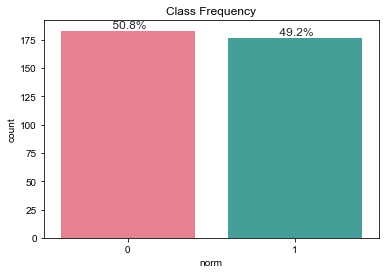

In [13]:
# Visualise class distribution
ax = sns.countplot(x='norm', data=df, palette="husl")
sns.set_theme(style='whitegrid')
plt.xticks(size=10)
ax.set_xticklabels(ax.get_xticklabels())
ax.set_xticklabels(ax.get_xticklabels())
plt.title("Class Frequency")

# Add % to bars in graph
total = len(df)
for p in ax.patches:
    percent = f'{100*p.get_height() / total: .1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percent, (x, y), ha='center', va='center')
plt.show()

In [14]:
# Word count of sentences
df['word_count'] = df['text'].str.findall(r'(\w+)').str.len()
df.head()

,text,norm,word_count
0,"Client agrees to pay to Company the sum of $5,000 (the “Contract Price”) to design and develop a website for Client (the “Client Website”) in accordance with the accompanying Scope of Work, attached to this Agreement as Exhibit A.",1,40
1,Company will use its best efforts to deliver the Client Website in the time frame specified in the Scope of Work.,1,21
2,"All written content submitted by Client for use in the Client Website must be typewritten, proofread and delivered to Company in the body of an email message or as a Microsoft Word electronic document or plaint text electronic document.",1,39
3,It is Client’s sole responsibility to check the accuracy of the written content and correct any errors prior to submission for final publication.,1,24
4,Client further agrees that Company may use and display the graphics and other web design elements of Client’s website as examples of Company website design and development work.,1,29


In [15]:
# Check summary statistics for word count
df.agg({
    'word_count': ['min', 'max','mean', 'median', 'skew']
})

,word_count
min,7.000000
max,555.000000
mean,43.619444
median,36.000000
skew,7.368855


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


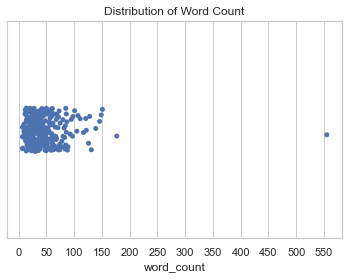

In [16]:
# Visualise spread of word count
fig, ax = plt.subplots()
plt.title("Distribution of Word Count")
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])
sns.stripplot(df['word_count'], ax=ax)
plt.show()

In [17]:
# Pandas profiling
profile = ProfileReport(df, title='Pandas Profiling Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

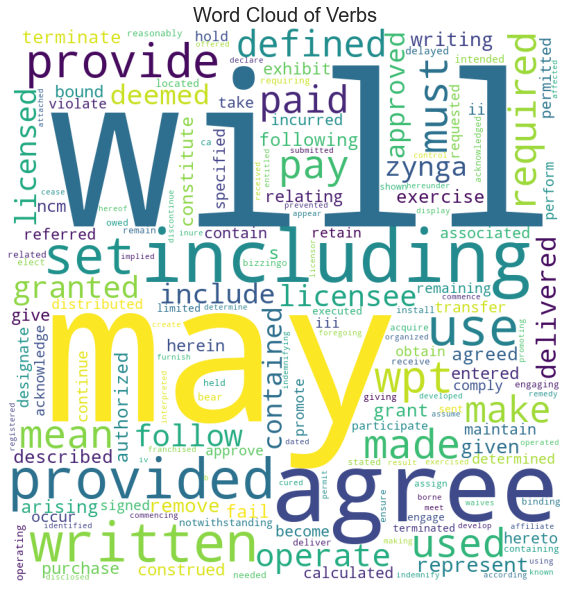

In [18]:
# Word cloud
comment_words = ' '

for val in df.text:
        bag = [ ]
        tokens = word_tokenize(val)
        tokens = [token.lower() for token in tokens if token.isalpha()]
        pos_tags = nltk.pos_tag(tokens)

        # Include modal verbs and other verb types
        select_pos = ['MD', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
        for word, tag in pos_tags:
            if tag in select_pos:
                bag.append((word))

        for i in range(len(bag)):
            bag[i] = bag[i].lower()
        comment_words += " ".join(bag)+" "

# Create word cloud
word_cloud = WordCloud(
                    width = 800, height = 800,
                    background_color='white',
                    min_font_size = 10
                    ).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Word Cloud of Verbs", fontsize=20)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)


In [19]:
#  Pre-process text with nltk

# Create variable for nltk lemmatizer method
wnl = WordNetLemmatizer()

# Create function to clean text
def clean_text(sentence):
     a = []
     
     # Split sentence into tokens
     tokens = word_tokenize(sentence)

     # Remove tokens that are not alphabetic (e.g. standalone punctuation)
     tokens = [token.lower() for token in tokens if token.isalpha()]

     # Reduce each word to its lemma
     for token in tokens:
          lem_word = wnl.lemmatize(token)
          a.append(lem_word)
     
     sentence = " ".join(a)
     return sentence

# Apply function to dataframe
df['clean_text'] = df['text'].apply(clean_text)

In [20]:
df.head()

,text,norm,word_count,clean_text
0,"Client agrees to pay to Company the sum of $5,000 (the “Contract Price”) to design and develop a website for Client (the “Client Website”) in accordance with the accompanying Scope of Work, attached to this Agreement as Exhibit A.",1,40,client agrees to pay to company the sum of the contract price to design and develop a website for client the client website in accordance with the accompanying scope of work attached to this agreement a exhibit a
1,Company will use its best efforts to deliver the Client Website in the time frame specified in the Scope of Work.,1,21,company will use it best effort to deliver the client website in the time frame specified in the scope of work
2,"All written content submitted by Client for use in the Client Website must be typewritten, proofread and delivered to Company in the body of an email message or as a Microsoft Word electronic document or plaint text electronic document.",1,39,all written content submitted by client for use in the client website must be typewritten proofread and delivered to company in the body of an email message or a a microsoft word electronic document or plaint text electronic document
3,It is Client’s sole responsibility to check the accuracy of the written content and correct any errors prior to submission for final publication.,1,24,it is client s sole responsibility to check the accuracy of the written content and correct any error prior to submission for final publication
4,Client further agrees that Company may use and display the graphics and other web design elements of Client’s website as examples of Company website design and development work.,1,29,client further agrees that company may use and display the graphic and other web design element of client s website a example of company website design and development work


In [21]:
# Assign target to a variable 'y'
y = df['norm']

# Vectorize text/features (y already in binary form)
tfidf = TfidfVectorizer(analyzer='word', max_features=2000, ngram_range=(1,3)) 
X = tfidf.fit_transform(df['clean_text'])
X

<360x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 16353 stored elements in Compressed Sparse Row format>

In [22]:
# Shape of features and target
X.shape, y.shape 

((360, 2000), (360,))

In [23]:
# The data is a bit uniformed (chunks of 1s followed by chunks of 0s) so let's shuffle the data
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [24]:
# Split data into training and testing sets. Shuffle data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0, stratify=y)

In [29]:
# Build Model
# Instantiate models
sgd = SGDClassifier()
lr = LogisticRegression(solver='lbfgs')
svc = LinearSVC()

In [36]:
# Function to calculate and print evaluation metrics

def print_scores(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Accuracy: {:.2}".format(accuracy_score(y_test, y_pred)))
    print("Classification Report: \n", classification_report(y_test, y_pred))
    print("-----------------------------------------------------------")

In [37]:
# Train models
for classifier in [sgd, lr, svc]:
    clf = classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_scores(y_pred, classifier)

Clf:  SGDClassifier
Accuracy: 0.88
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.84      0.87        37
           1       0.84      0.91      0.88        35

    accuracy                           0.88        72
   macro avg       0.88      0.88      0.87        72
weighted avg       0.88      0.88      0.87        72

-----------------------------------------------------------
Clf:  LogisticRegression
Accuracy: 0.82
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83        37
           1       0.84      0.77      0.81        35

    accuracy                           0.82        72
   macro avg       0.82      0.82      0.82        72
weighted avg       0.82      0.82      0.82        72

-----------------------------------------------------------
Clf:  LinearSVC
Accuracy: 0.88
Classification Report: 
               precision    recall  f1-score  

In [28]:
# Making predictions

# x = ['Arizona may sublicense the licenses granted herein to its Affiliates and Third Parties in the ordinary course of business in support of its and its Affiliates’ business, but not for the independent use of Third Parties, and the Company may sublicense the licenses granted herein to Third Parties, its Subsidiaries, AWP, controlled Affiliates, or any holding company that is a direct or indirect parent of the Company in the ordinary course of business in support of its and its Subsidiaries’ or controlled Affiliates’ business, but not for the independent use of Third Parties (each such Affiliate, Third Party, AWP or Subsidiary, a “Sublicensee”)']
x = ['In this Agreement, “we,” “us” and “our” refers to Pizza Fusion Holding, Inc., the franchisor. ']
# x = ['This Agreement may be signed in counterparts and shall be deemed one original instrument.']
# x = ['XIMAGE agrees to respond to any telephone call made, within 30 minutes.']
xt = tfidf.transform(x)
print(clf.predict(xt))

[0]


In [29]:
# Save vectorizer
# joblib.dump(tfidf, '../models/BinaryLabelVectorizer.pkl')

In [30]:
# Save model
# joblib.dump(clf, '../models/BinaryLabelModel_NonNN.pkl')